# Canada FP1 Analysis

**Description:**  
This notebook performs an exploratory data analysis of the Free Practice 1 (FP1) session for the 2025 Canada Grand Prix using the FastF1 library.  
It begins by loading telemetry and lap data, followed by extracting relevant driver and compound information.  
Custom utility functions are defined for processing time deltas, and visualizations are prepared using libraries like Matplotlib and Seaborn.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import fastf1.plotting
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
from fastf1 import utils
import matplotlib.pyplot as plt
from fastf1.utils import delta_time
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib as mpl
from typing import Union
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

In [35]:
# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme='fastf1' )


# load a session and its telemetry data
session = fastf1.get_session(2025, 'Belgian Grand Prix', 'SQ')
session.load()
# In this way i Can exclude the box laps
laps = session.laps

results = session.results

# Pick just the accurate laps
#laps = laps[laps['IsAccurate']==True]

circuit_info = session.get_circuit_info()

weather = session.weather_data



core           INFO 	Loading data for Belgian Grand Prix - Sprint Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	Sprint Qualifying is not supported by Ergast! Limited results are calculated from timing data.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '4', '16', '31', '55', '87', '10', '6', '5', '30', '22', '63', '14', '18', '23', '27', '44'

In [36]:
display(laps)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:19:21.823000,PIA,81,NaT,1.0,1.0,0 days 00:17:07.613000,NaT,NaT,0 days 00:00:58.168000,...,True,McLaren,0 days 00:17:07.613000,2025-07-25 14:32:51.481,1,NaN,False,,False,False
1,0 days 00:21:03.592000,PIA,81,0 days 00:01:41.769000,2.0,1.0,NaT,NaT,0 days 00:00:30.077000,0 days 00:00:43.541000,...,True,McLaren,0 days 00:19:21.823000,2025-07-25 14:35:05.691,1,NaN,False,,False,True
2,0 days 00:23:27.948000,PIA,81,0 days 00:02:24.356000,3.0,1.0,NaT,0 days 00:23:23.772000,0 days 00:00:44.398000,0 days 00:01:01.274000,...,True,McLaren,0 days 00:21:03.592000,2025-07-25 14:36:47.460,1,NaN,False,,False,False
3,0 days 00:42:31.992000,PIA,81,NaT,4.0,2.0,0 days 00:40:26.509000,NaT,NaT,0 days 00:00:56.600000,...,True,McLaren,0 days 00:23:27.948000,2025-07-25 14:39:11.816,12,NaN,False,,False,False
4,0 days 00:44:13.728000,PIA,81,0 days 00:01:41.736000,5.0,2.0,NaT,NaT,0 days 00:00:30.092000,0 days 00:00:43.514000,...,True,McLaren,0 days 00:42:31.992000,2025-07-25 14:58:15.860,1,NaN,True,TRACK LIMITS AT TURN 4 LAP 6,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0 days 00:49:48.713000,BEA,87,0 days 00:01:42.019000,8.0,3.0,NaT,NaT,0 days 00:00:29.854000,0 days 00:00:44.043000,...,True,Haas F1 Team,0 days 00:48:06.694000,2025-07-25 15:03:50.562,1,NaN,False,,False,True
181,0 days 00:52:09.817000,BEA,87,0 days 00:02:21.104000,9.0,3.0,NaT,0 days 00:52:06.016000,0 days 00:00:38.240000,0 days 00:01:01.734000,...,True,Haas F1 Team,0 days 00:49:48.713000,2025-07-25 15:05:32.581,12,NaN,False,,False,False
182,0 days 01:09:25.044000,BEA,87,NaT,10.0,4.0,0 days 01:07:01.618000,NaT,NaT,0 days 00:00:57.504000,...,True,Haas F1 Team,0 days 00:52:09.817000,2025-07-25 15:07:53.685,21,NaN,False,,False,False
183,0 days 01:11:06.901000,BEA,87,0 days 00:01:41.857000,11.0,4.0,NaT,NaT,0 days 00:00:29.802000,0 days 00:00:43.928000,...,True,Haas F1 Team,0 days 01:09:25.044000,2025-07-25 15:25:08.912,1,NaN,False,,False,True


In [37]:
drivers =laps['Driver'].unique()
compounds = laps['Compound'].unique()


In [38]:
def timedelta_to_seconds(td: pd.Timedelta) -> float:
    """
    Convert a pandas Timedelta to a float representing the total seconds.
    
    Parameters:
    - td: pd.Timedelta
    
    Returns:
    - float: total seconds
    """
    return td.total_seconds()

In [39]:
# Transform the laps in total seconds
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()



# order the team from the fastest (lowest median lap time) to slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)

# make a color palette associating team names to hex codes

specific_color_kick_sauber = '#90EE90'  # Light green
specific_color_alpha_tauri = '#1634cb'  # Specific blue color

def get_team_color(team):
    if team == 'Kick Sauber' or team == 'Alfa Romeo':
        return specific_color_kick_sauber
    elif team == 'AlphaTauri':
        return specific_color_alpha_tauri
    else:
        try:
            return fastf1.plotting.team_color(team)
        except KeyError:
            return '#000000'  # Default color (black) if team is not recognized

team_palette = {team: get_team_color(team) for team in team_order}


/Users/PietroPaolo/opt/anaconda3/envs/progLab/lib/python3.9/site-packages/fastf1/plotting/_plotting.py:249: FutureWarning: INCOMPATIBLE with 2025 season!The function `team_color` is deprecated and will be removed in a future version. Use `fastf1.plotting.get_team_color` instead.
  warnings.warn("INCOMPATIBLE with 2025 season!The function `team_color` "
_plotting    WARNING 	Correcting invalid user input ' bulls' to 'red bull'.
_plotting    WARNING 	Correcting invalid user input 'haas  ' to 'haas'.
_plotting    WARNING 	Correcting invalid user input 'red bull ' to 'red bull'.


In [40]:
colors_pilots = {
    # Red Bull Racing
    "VER": "blue",  # Max Verstappen
    "TSU": "blue",  # Liam Lawson

    # McLaren
    "NOR": "orange",  # Lando Norris
    "PIA": "orange",  # Oscar Piastri
    "DUN": "orage",

    # Ferrari
    "LEC": "red",    # Charles Leclerc§
    "HAM": "red",    # Lewis Hamilton
    "BEG": "red",

    # Mercedes
    "RUS": "grey",   # George Russell
    "ANT": "grey",   # Andrea Kimi Antonelli

    # Aston Martin
    "ALO": "green",  # Fernando Alonso
    "STR": "green",  # Lance Stroll

    # Alpine
    "GAS": "pink",   # Pierre Gasly
    "DOO": "pink",   # Jack Doohan
    "COL": "pink",   # Jack Doohan

    # Haas
    "OCO": "olive",  # Esteban Ocon
    "BEA": "olive",  # Oliver Bearman
    "HIR": "olive", #Hirakawa

    # Racing Bulls (formerly AlphaTauri)
    "HAD": "#9932CC",  # Isack Hadjar
    "LAW": "#9932CC",  # Yuki Tsunoda

    # Williams
    "ALB": "navy",   # Alexander Albon
    "SAI": "navy",   # Carlos Sainz Jr.

    # Sauber (transitioning to Audi)
    "HUL": "lime",   # Nico Hülkenberg
    "BOR": "lime",   # Gabriel Bortoleto
}

In [41]:
'''
def interpolate_dataframe(df):
    # Creating a new DataFrame with interpolated data
    new_df = pd.DataFrame()

    for column in df.columns:
        # Interpolating each column
        original_data = df[column].to_numpy()
        interleaved_data = np.empty(2 * len(original_data) - 1, dtype=original_data.dtype)
        
        # Fill with original data in even indices
        interleaved_data[0::2] = original_data

        # Check the data type of the column
        if np.issubdtype(original_data.dtype, np.number):
            # Interpolated data for numerical columns
            interleaved_data[1::2] = (original_data[:-1] + original_data[1:]) / 2
        elif np.issubdtype(original_data.dtype, np.datetime64):
            # Interpolated data for datetime columns
            interleaved_data[1::2] = (original_data[:-1] + (original_data[1:] - original_data[:-1]) / 2)
        elif np.issubdtype(original_data.dtype, np.bool_):
            # For boolean columns, use logical interpolation (e.g., keep the previous value)
            interleaved_data[1::2] = original_data[:-1]
        else:
            # For any other types, fallback to forward fill
            interleaved_data[1::2] = original_data[:-1]

        # Assigning the new column to the new DataFrame
        new_df[column] = interleaved_data

    return new_df
'''

'\ndef interpolate_dataframe(df):\n    # Creating a new DataFrame with interpolated data\n    new_df = pd.DataFrame()\n\n    for column in df.columns:\n        # Interpolating each column\n        original_data = df[column].to_numpy()\n        interleaved_data = np.empty(2 * len(original_data) - 1, dtype=original_data.dtype)\n        \n        # Fill with original data in even indices\n        interleaved_data[0::2] = original_data\n\n        # Check the data type of the column\n        if np.issubdtype(original_data.dtype, np.number):\n            # Interpolated data for numerical columns\n            interleaved_data[1::2] = (original_data[:-1] + original_data[1:]) / 2\n        elif np.issubdtype(original_data.dtype, np.datetime64):\n            # Interpolated data for datetime columns\n            interleaved_data[1::2] = (original_data[:-1] + (original_data[1:] - original_data[:-1]) / 2)\n        elif np.issubdtype(original_data.dtype, np.bool_):\n            # For boolean columns,

In [42]:
from scipy.interpolate import PchipInterpolator

def interpolate_dataframe(df):
    target_points=5000
    new_df = pd.DataFrame()
    n = len(df)

    original_index = np.linspace(0, 1, n)
    new_index = np.linspace(0, 1, target_points)

    for column in df.columns:
        original_data = df[column].to_numpy()
        dtype = original_data.dtype

        # Handle continuous numerical values
        if np.issubdtype(dtype, np.floating):
            interpolator = PchipInterpolator(original_index, original_data)
            new_data = interpolator(new_index)

        # Handle datetime64
        elif np.issubdtype(dtype, np.datetime64):
            time_int = original_data.astype('datetime64[ns]').astype('int64')
            interpolator = PchipInterpolator(original_index, time_int)
            new_data = pd.to_datetime(interpolator(new_index))

        # Handle timedelta64
        elif np.issubdtype(dtype, np.timedelta64):
            time_int = original_data.astype('timedelta64[ns]').astype('int64')
            interpolator = PchipInterpolator(original_index, time_int)
            new_data = pd.to_timedelta(interpolator(new_index))

        # Handle integer-like data (e.g., gears) – round PCHIP
        elif np.issubdtype(dtype, np.integer):
            interpolator = PchipInterpolator(original_index, original_data)
            new_data = np.round(interpolator(new_index)).astype(original_data.dtype)

        # Handle booleans – use nearest (forward-fill style)
        elif np.issubdtype(dtype, np.bool_):
            nearest_indices = np.clip(np.round(new_index * (n - 1)).astype(int), 0, n - 1)
            new_data = original_data[nearest_indices]

        # Handle strings/objects – use nearest
        else:
            nearest_indices = np.clip(np.round(new_index * (n - 1)).astype(int), 0, n - 1)
            new_data = original_data[nearest_indices]

        new_df[column] = new_data

    return new_df

In [43]:
interpolate_dataframe(transformed_laps.pick_drivers('LEC').pick_fastest().get_car_data().add_distance())

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2025-07-25 15:24:43.620000000,11395.000000,247.000000,6,100.0,False,12,car,0 days 00:00:00.117000,0 days 01:08:59.752000,8.027500
1,2025-07-25 15:24:43.639384576,11410.568928,247.629650,6,100.0,False,12,car,0 days 00:00:00.136384468,0 days 01:08:59.771384468,9.387422
2,2025-07-25 15:24:43.658556160,11426.077616,248.246059,6,100.0,False,12,car,0 days 00:00:00.155556070,0 days 01:08:59.790556070,10.733384
3,2025-07-25 15:24:43.677509888,11441.525678,248.848201,6,100.0,False,12,car,0 days 00:00:00.174509996,0 days 01:08:59.809509996,12.065098
4,2025-07-25 15:24:43.696241408,11456.912731,249.435047,6,100.0,False,12,car,0 days 00:00:00.193241434,0 days 01:08:59.828241434,13.382275
...,...,...,...,...,...,...,...,...,...,...,...
4995,2025-07-25 15:26:24.647049472,10743.197716,235.107040,6,100.0,False,12,car,0 days 00:01:41.144049382,0 days 01:10:40.779049382,6950.098757
4996,2025-07-25 15:26:24.679364096,10811.986034,235.598072,6,100.0,False,12,car,0 days 00:01:41.176364209,0 days 01:10:40.811364209,6952.238437
4997,2025-07-25 15:26:24.712311808,10892.766106,236.077451,6,100.0,False,12,car,0 days 00:01:41.209311991,0 days 01:10:40.844311991,6954.422434
4998,2025-07-25 15:26:24.745865984,10986.462554,236.544866,6,100.0,False,12,car,0 days 00:01:41.242866122,0 days 01:10:40.877866122,6956.648723


In [44]:
# Replace these with your actual telemetry-framework imports:
# from telemetry import transformed_laps, circuit_info, interpolate_dataframe, session

import warnings

# ignore only the FastF1 deprecation warning about delta_time
warnings.filterwarnings(
    "ignore",
    message="`utils.delta_time` is considered deprecated.*",
    category=FutureWarning
)

class FastestLap:
    """
    Wraps a fastest-lap record and provides convenience accessors.
    Expects lap to have ['Driver','Sector1Time','Sector2Time'] and get_car_data().
    """
    def __init__(self, lap):
        self.name = lap['Driver']
        self.s1_time = lap['Sector1Time']
        self.s2_time = lap['Sector2Time']
        df = lap.get_car_data().add_distance()
        self.df = interpolate_dataframe(df)

    @property
    def sector_distances(self):
        d1 = self.df[self.df['Time'] <= self.s1_time]['Distance'].max()
        d2 = self.df[self.df['Time'] <= (self.s1_time + self.s2_time)]['Distance'].max()
        return d1, d2

from scipy.signal import savgol_filter

def compute_acceleration(df, smooth=True, clip_range=(-6, 6)):
    df = df.copy()
    df['Speed_ms'] = df['Speed'] / 3.6

    # Use distance for safer numerical stability
    df['Distance'] = df['Distance'].interpolate()
    dv_dx = np.gradient(df['Speed_ms'], df['Distance'])

    # Chain rule: a = dv/dx * v
    df['Acc'] = dv_dx * df['Speed_ms']

    if smooth:
        try:
            df['Acc'] = savgol_filter(df['Acc'], window_length=27, polyorder=2)
        except:
            pass

    if clip_range:
        df['Acc'] = df['Acc'].clip(*clip_range)

    return df

def compare_laps(drivers, channels=None, session_label="", driver_color_map=None):
    """
    Compare up to three drivers' laps (fastest or specific).

    Parameters:
    - drivers: list (uses fastest) or dict with lap selection (e.g. {'LEC': 'fastest', 'VER': 12})
    - channels: list of telemetry fields to plot
    - session_label: optional label for plot title
    - driver_color_map: optional manual override of driver colors
    """
    # Fallback shades for duplicate team colors
    fallback_shades = {
        'red': ['white', 'lightcoral'],
        'blue': ['cyan', 'lightblue'],
        'orange': ['gold', 'wheat'],
        'grey': ['white', 'silver'],
        'green': ['lime', 'springgreen'],
        'pink': ['violet', 'lightpink'],
        'olive': ['khaki'],
        'navy': ['skyblue'],
        '#9932CC': ['plum'],
        'lime': ['yellowgreen']
    }

    # Normalize drivers input
    if isinstance(drivers, dict):
        driver_lap_map = drivers
        driver_list = list(drivers.keys())
    else:
        driver_list = drivers
        driver_lap_map = {d: 'fastest' for d in drivers}

    if not (1 <= len(driver_list) <= 3):
        raise ValueError("Must compare between 1 and 3 drivers.")

    default_channels = ['Speed', 'Throttle', 'Brake', 'RPM', 'nGear']
    channels = channels or default_channels

    units = {
        'Speed': 'km/h', 'Throttle': '%', 'Brake': '%', 'RPM': 'rpm',
        'nGear': '', 'DRS': ''
    }

    # Load and prepare data
    laps = []
    lap_objs = []

    for driver in driver_list:
        lap_id = driver_lap_map[driver]
        if lap_id == 'fastest':
            lap = transformed_laps.pick_drivers(driver).pick_fastest()
        else:
            try:
                lap = transformed_laps.pick_drivers(driver).pick_laps(int(lap_id)).iloc[0]
            except Exception as e:
                raise ValueError(f"Invalid lap selection for {driver}: {lap_id}") from e

        fl = FastestLap(lap)
        fl.df = compute_acceleration(fl.df)
        laps.append(fl)
        lap_objs.append(lap)

    avg_air_temp = weather['AirTemp'].mean()
    avg_track_temp = weather['TrackTemp'].mean()

    lap_times = [lap['LapTime'].total_seconds() for lap in lap_objs]
    baseline_idx = lap_times.index(min(lap_times))
    baseline_name = driver_list[baseline_idx]

    s1_dist, s2_dist = laps[baseline_idx].sector_distances
    corner_distances = circuit_info.corners['Distance'].values

    # Assign colors with fallback shades
    used_colors = {}
    palette = []

    for driver in driver_list:
        base_color = driver_color_map.get(driver) if driver_color_map and driver in driver_color_map else colors_pilots.get(driver, 'white')
        count = used_colors.get(base_color, 0)
        if count == 0:
            palette.append(base_color)
        else:
            fallback = fallback_shades.get(base_color, ['white'])
            alt_color = fallback[count - 1] if count - 1 < len(fallback) else 'white'
            palette.append(alt_color)
        used_colors[base_color] = count + 1

    # Setup figure
    n_plots = len(channels) + 1 + (1 if len(driver_list) > 1 else 0)
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3.5 * n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]
    plt.style.use('dark_background')

    # Plot telemetry channels
    for i, ch in enumerate(channels):
        ax = axes[i]
        if ch not in laps[baseline_idx].df.columns:
            ax.set_visible(False)
            continue
        for lap, col, driver in zip(laps, palette, driver_list):
            ax.plot(lap.df['Distance'], lap.df[ch], color=col,
                    linestyle='-', label=f"{driver} {ch}")
        ax.set_ylabel(f"{ch} ({units.get(ch, '')})", color='white')
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.tick_params(colors='white')
        ax.axvline(s1_dist, color='white', linestyle='--')
        ax.axvline(s2_dist, color='white', linestyle='--')
        for num, d in enumerate(corner_distances, start=1):
            ax.text(d, ax.get_ylim()[0], str(num), color='white', fontsize=8,
                    ha='center', va='bottom')

    # Plot acceleration
    ax_acc = axes[len(channels)]
    for lap, col, driver in zip(laps, palette, driver_list):
        ax_acc.plot(lap.df['Distance'], lap.df['Acc'], color=col,
                    linestyle='-', label=f"{driver} Acc")
    ax_acc.set_ylabel('Acc (m/s²)', color='white')
    ax_acc.legend(loc='upper right')
    ax_acc.grid(True, linestyle='--', linewidth=0.5)
    ax_acc.tick_params(colors='white')

    # Delta time
    if len(driver_list) > 1:
        ax_dt = axes[-1]
        ref_lap = lap_objs[baseline_idx]
        for idx, comp_lap in enumerate(lap_objs):
            if idx == baseline_idx:
                continue
            delta_series, ref_tel, comp_tel = delta_time(ref_lap, comp_lap)
            ax_dt.plot(ref_tel['Distance'], delta_series,
                       color=palette[idx], linestyle='-',
                       label=f"Δ ({driver_list[idx]} - {baseline_name})")
        ax_dt.set_ylabel('Δ Time (s)', color='white')
        ax_dt.axhline(0, color='white', linestyle='--')
        ax_dt.grid(True, linestyle='--', linewidth=0.5)
        ax_dt.tick_params(colors='white')
        ax_dt.set_xlabel('Distance (m)', color='white')
        ax_dt.xaxis.set_major_locator(plt.MultipleLocator(500))
        ax_dt.xaxis.set_minor_locator(plt.MultipleLocator(100))
        ax_dt.legend(loc='upper right', title=f"Benchmark: {baseline_name}")

    # Lap time annotations
        labels = []
        for i, (name, secs) in enumerate(zip(driver_list, lap_times)):
            if pd.isna(secs):
                label = f"{name}: NaN"
            else:
                mins = int(secs // 60)
                rem = secs - mins * 60
                label = f"{name}: {mins}:{rem:06.3f}"
                if i == 0:
                    label += f"   AIR: {avg_air_temp:.1f}°C  TRACK: {avg_track_temp:.1f}°C"
            labels.append(label)

    fig.text(0.02, 0.98, "\n".join(labels), ha='left', va='top',
             color='white', fontsize=10,
             bbox=dict(facecolor='black', alpha=0.5, pad=4))

    fig.text(0.9, 0.96, "Provided by: Pietro Paolo Melella",
             ha='right', va='bottom', color='white', fontsize=15)
    title = (f"{session.event['EventName']} {session.event.year} {session_label}"
             if session_label else f"{session.event['EventName']} {session.event.year}")
    fig.suptitle(title, color='white')
    fig.subplots_adjust(top=0.92)
    plt.tight_layout(rect=[0, 0, 0.90, 0.97])
    plt.show()

### 🛰️ Telemetry Analysis

This section visualizes telemetry data from the FP1 session. The plots help compare driving styles, speeds, braking points, and throttle application across different drivers.  
Telemetry is essential for identifying performance differences at specific parts of the circuit, such as corner entries and exits.

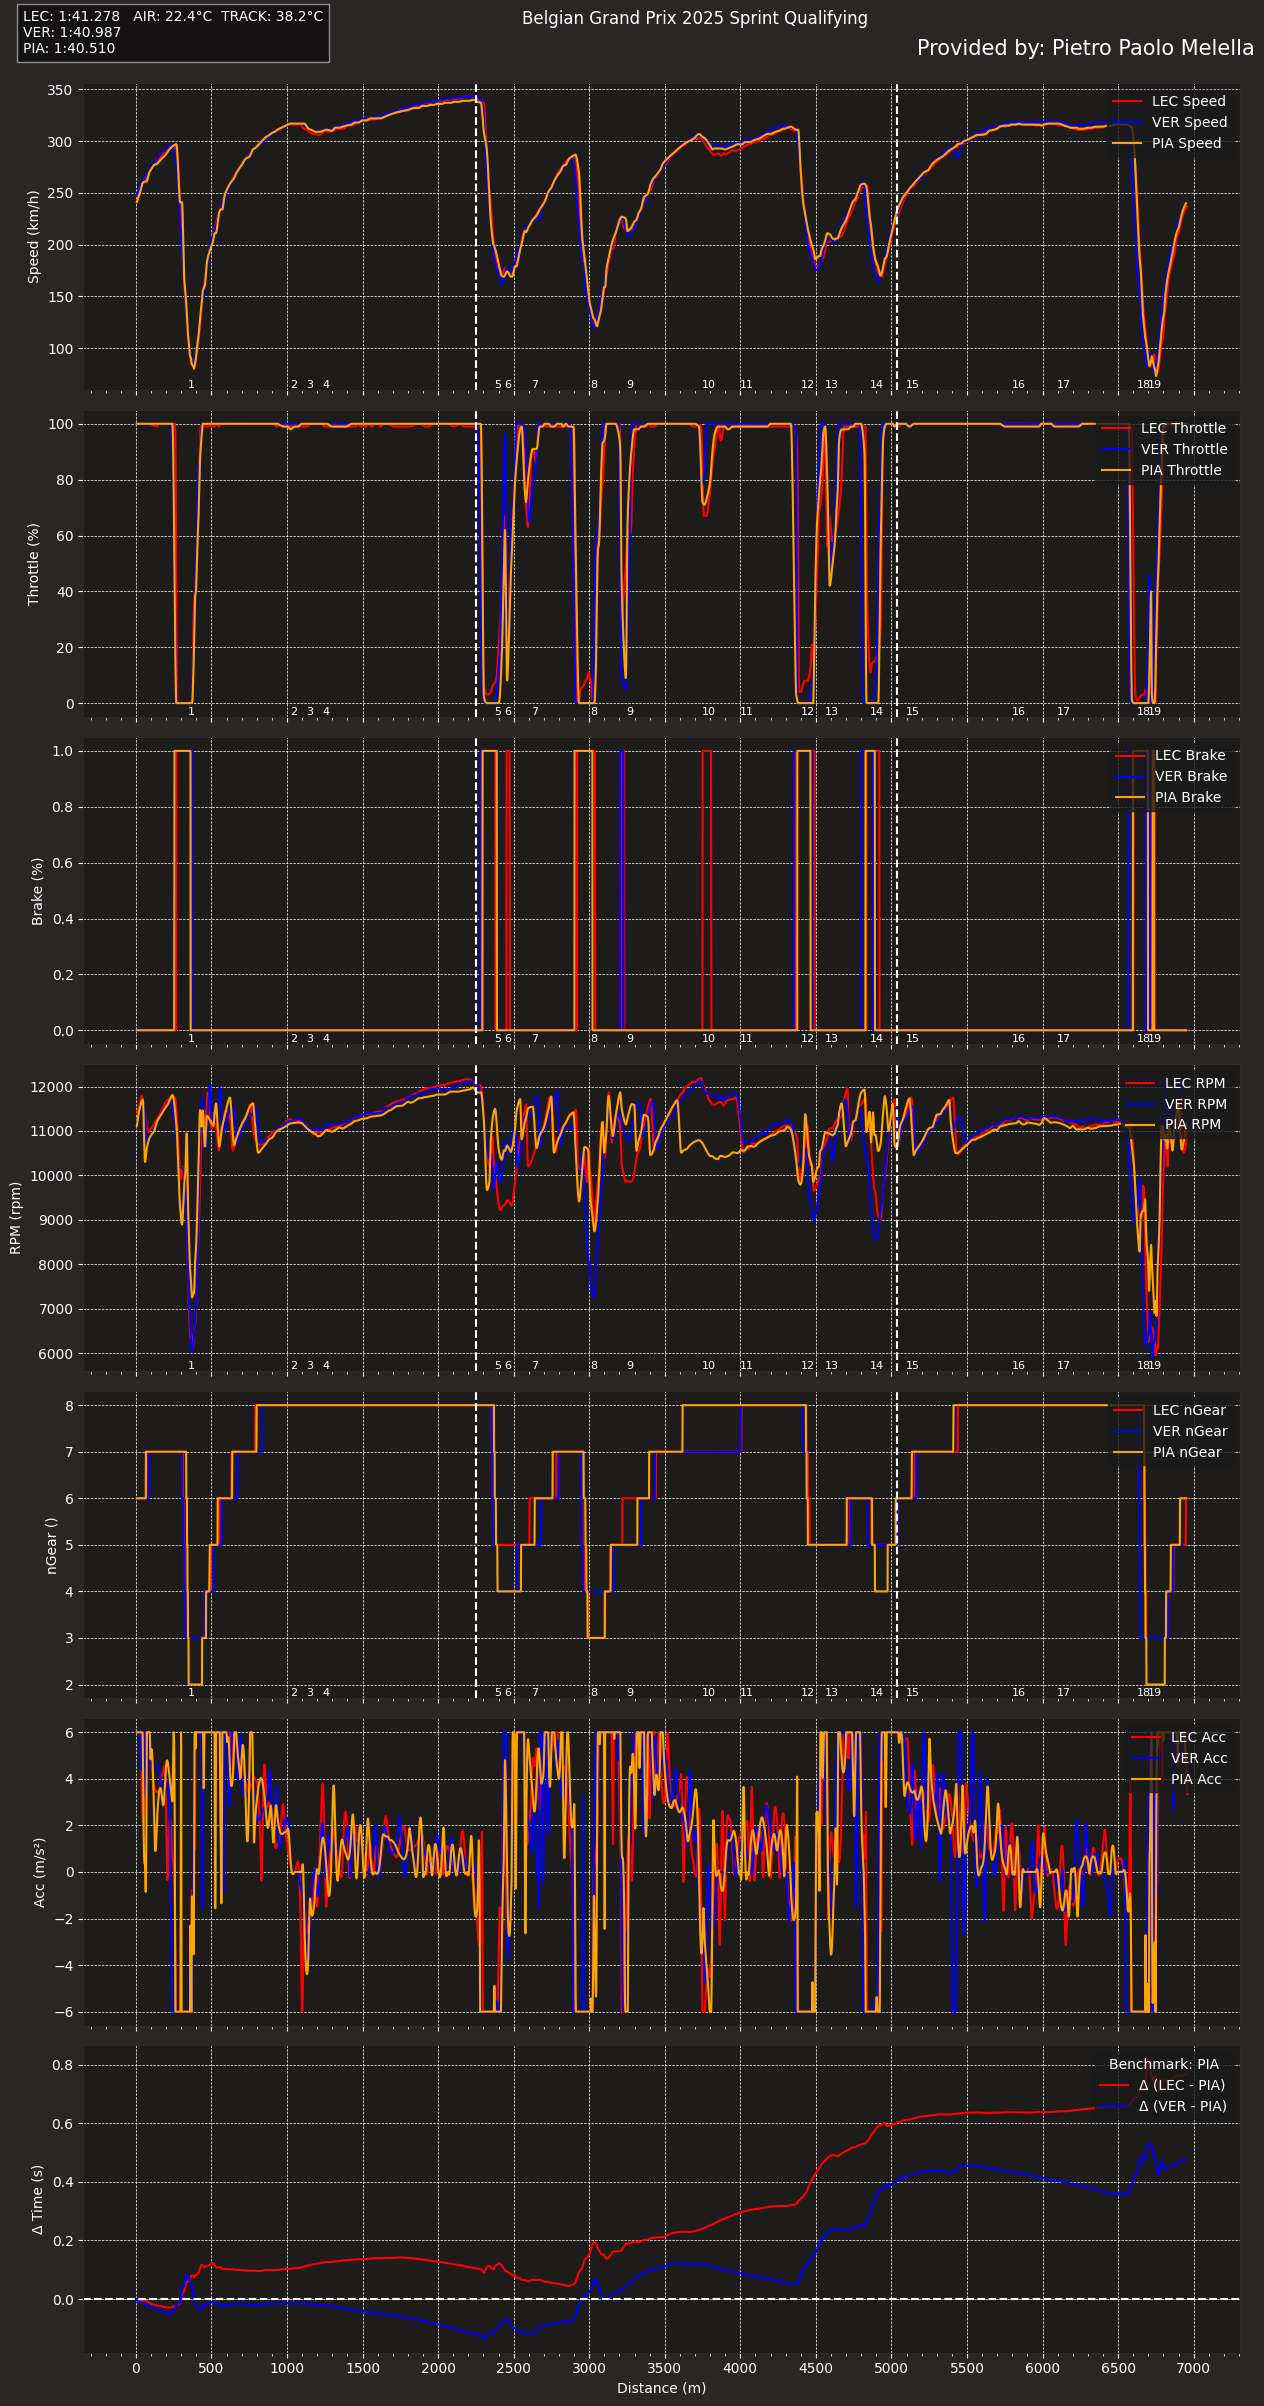

In [45]:
compare_laps(
    {'LEC': 'fastest', 'VER': 'fastest', 'PIA': 'fastest'},
    session_label='Sprint Qualifying'
)

In [46]:
class CornerAnalysis:
    """
    Analyze telemetry for one or more corners (or a corner range).
    """

    def __init__(self, drivers, corner_idxs, before=50, after=50, session_label=''):
        if not isinstance(drivers, dict):
            raise ValueError("drivers must be a dict of form {'LEC': 'fastest' or lap_number_str}")

        if not (1 <= len(drivers) <= 4):
            raise ValueError("drivers dict must contain between 1 and 4 entries")

        self.driver_lap_map = drivers
        self.drivers = list(drivers.keys())
        self.before = before
        self.after = after
        self.session_label = session_label

        # Normalize user-provided corner_idxs (1-based) to zero-based list
        if isinstance(corner_idxs, int):
            self.corner_list = [corner_idxs - 1]
        elif hasattr(corner_idxs, '__iter__'):
            try:
                ints = [int(x) for x in corner_idxs]
            except Exception:
                raise ValueError("corner_idxs iterable must contain integers")
            if any(i < 1 for i in ints):
                raise ValueError("corner_idxs must be 1-based positive integers")
            self.corner_list = [i - 1 for i in ints]
        else:
            raise ValueError("corner_idxs must be an int or iterable of ints (1-based)")

        self.start_idx = min(self.corner_list)
        self.end_idx   = max(self.corner_list)

        self.telemetry = {}
        self._load_data()
        self.palette = self._assign_colors()

    def _load_data(self):
        """Load and interpolate telemetry for each driver based on lap selection."""
        for d, lap_id in self.driver_lap_map.items():
            if lap_id == 'fastest':
                lap = transformed_laps.pick_drivers(d).pick_fastest()
            else:
                try:
                    lap_num = int(lap_id)
                    lap = transformed_laps.pick_drivers(d).pick_laps(lap_num).iloc[0]
                except Exception as e:
                    raise ValueError(f"Invalid lap selection for {d}: {lap_id}") from e

            df = lap.get_car_data().add_distance()
            df = interpolate_dataframe(df)
            self.telemetry[d] = df

    def _assign_colors(self):

        fallback_shades = {
            'red': ['white', 'lightcoral'],
            'blue': ['cyan', 'lightblue'],
            'orange': ['gold', 'wheat'],
            'grey': ['white', 'silver'],
            'green': ['lime', 'springgreen'],
            'pink': ['violet', 'lightpink'],
            'olive': ['khaki'],
            'navy': ['skyblue'],
            '#9932CC': ['plum'],
            'lime': ['yellowgreen']
        }

        used_colors = {}
        palette = []

        for driver in self.drivers:
            base_color = colors_pilots.get(driver, 'white')
            count = used_colors.get(base_color, 0)
            if count == 0:
                palette.append(base_color)
            else:
                fallback = fallback_shades.get(base_color, ['white'])
                alt_color = fallback[count - 1] if count - 1 < len(fallback) else 'white'
                palette.append(alt_color)
            used_colors[base_color] = count + 1

        return palette

    def get_corner_df(self, driver):
        df = self.telemetry[driver]
        corners = circuit_info.corners['Distance'].values
        start_dist = corners[self.start_idx] - self.before
        end_dist   = corners[self.end_idx]   + self.after
        dfc = df[(df['Distance'] >= start_dist) & (df['Distance'] <= end_dist)].copy()
        dfc['Speed_ms'] = dfc['Speed'] / 3.6
        dfc['Sess_s']   = dfc['SessionTime'].dt.total_seconds()
        dfc['Acc']      = np.gradient(dfc['Speed_ms'], dfc['Sess_s'])
        return dfc

    def plot_all(self):
        channels = ['Speed', 'Acc', 'Throttle', 'Brake']
        n = len(channels) + 1  # Extra for scatter
        fig, axs = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=False)
        plt.style.use('dark_background')

        event = session.event['EventName']
        year  = session.event.year

        if len(self.corner_list) == 1:
            corner_label = f"Corner {self.corner_list[0] + 1}"
        else:
            sorted_idxs = sorted(self.corner_list)
            runs = (sorted_idxs[i] + 1 == sorted_idxs[i+1] for i in range(len(sorted_idxs)-1))
            if all(runs):
                corner_label = f"Corners {sorted_idxs[0]+1}-{sorted_idxs[-1]+1}"
            else:
                corner_label = "Corners " + ",".join(str(i+1) for i in sorted_idxs)

        title = f"{event} {year} {self.session_label} {corner_label}"
        fig.suptitle(title, color='white')
        fig.subplots_adjust(top=0.92)

        # Line plots
        for idx, ch in enumerate(channels):
            ax = axs[idx]
            for d, col in zip(self.drivers, self.palette):
                dfc = self.get_corner_df(d)
                ax.plot(dfc['Distance'], dfc[ch], color=col, label=f"{d} {ch}")
            ax.set_ylabel(ch, color='white')
            ax.legend(loc='upper right')
            ax.grid(True, linestyle='--', linewidth=0.5)
            ax.tick_params(colors='white')
            if idx == len(channels) - 1:
                ax.set_xlabel('Distance (m)', color='white')
            for apex_idx in self.corner_list:
                ax.axvline(circuit_info.corners['Distance'].values[apex_idx], color='white', linestyle=':')

        # Scatter plot for Throttle
        ax_throttle_alt = axs[-1]
        for d, col in zip(self.drivers, self.palette):
            dfc = self.get_corner_df(d)
            if dfc.empty or 'Distance' not in dfc or 'Throttle' not in dfc:
                print(f"[WARN] No telemetry data for driver {d} — skipping scatter plot.")
                continue
            x_vals = dfc['Distance'].to_numpy()
            y_vals = dfc['Throttle'].to_numpy()
            ax_throttle_alt.scatter(x_vals, y_vals, s=10, color=col, alpha=0.6, label=d)

        ax_throttle_alt.set_xlabel('Distance (m)', color='white')
        ax_throttle_alt.set_ylabel('Throttle %', color='white')
        ax_throttle_alt.set_title('Throttle (Scatter View)', color='white')
        ax_throttle_alt.legend(loc='upper right')
        ax_throttle_alt.grid(True, linestyle='--', linewidth=0.5)
        ax_throttle_alt.tick_params(colors='white')

        # Signature
        fig.text(0.95, 0.91, "Provided by: Pietro Paolo Melella", ha='right', va='bottom', color='white', fontsize=15)
        plt.tight_layout(rect=[0, 0, 0.95, 0.93])
        plt.show()

### 🔍 Turns 6–7 (Left-Right Chicane) Analysis

This section features a medium-speed left-right chicane.  
Precision over the curbs is crucial to maintain momentum while avoiding track limits.  
Use this section to analyze steering input smoothness, curb usage, and exit stability.

### 🔍 Turns 13–14 (Final Chicane) Analysis

This is the famous high-speed chicane leading onto the main straight.  
Drivers must brake late and aggressively while managing risk near the Wall of Champions.  
Use this section to evaluate braking consistency, curb aggression, and optimal traction on exit.

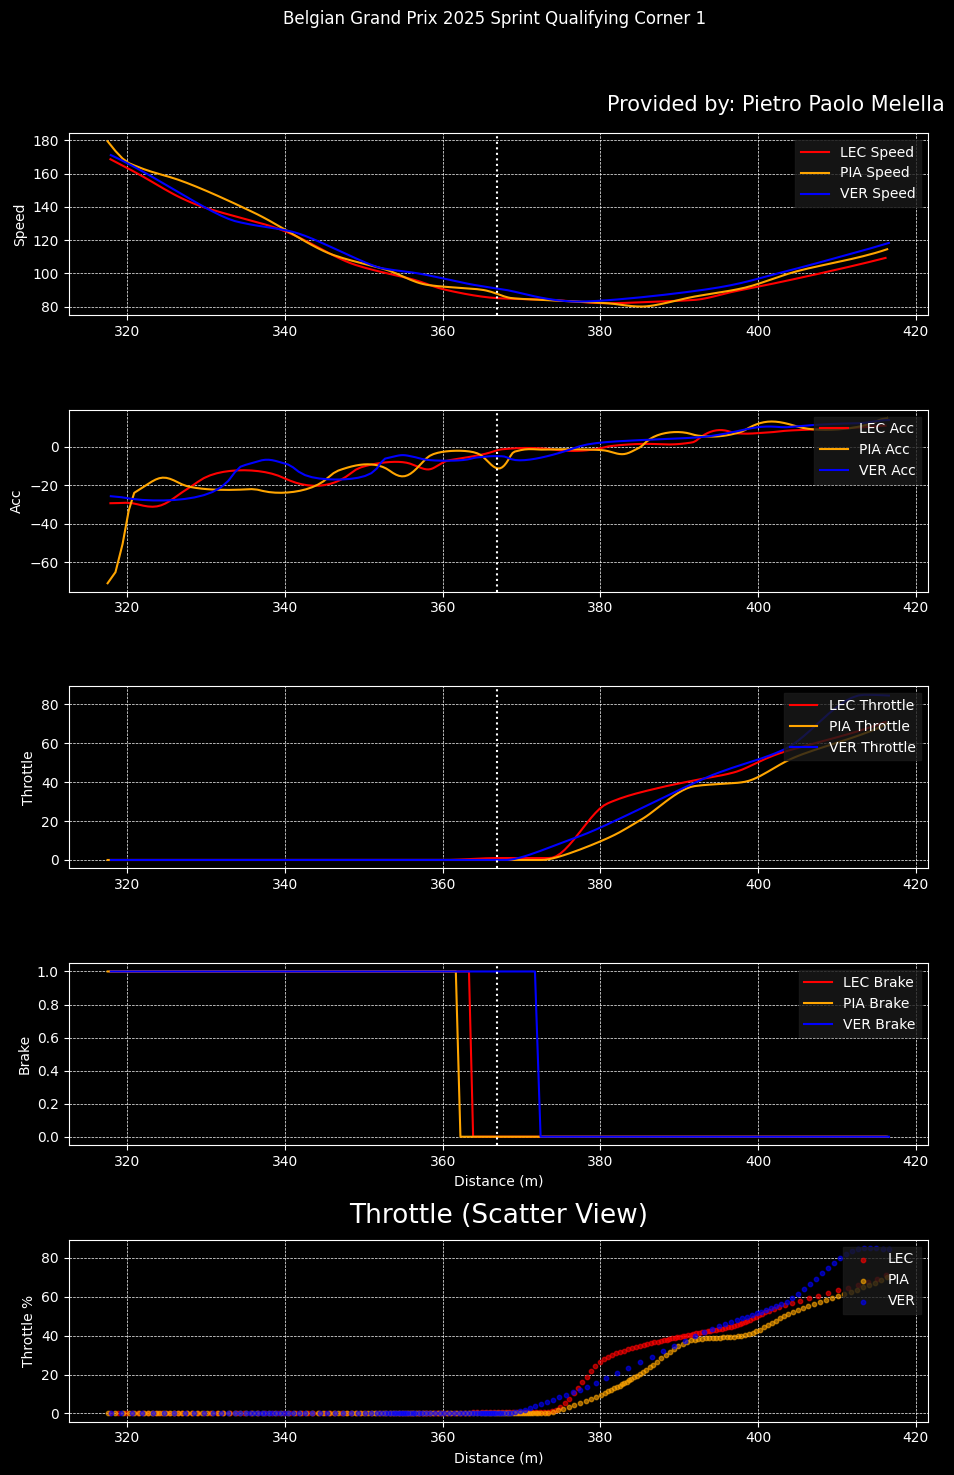

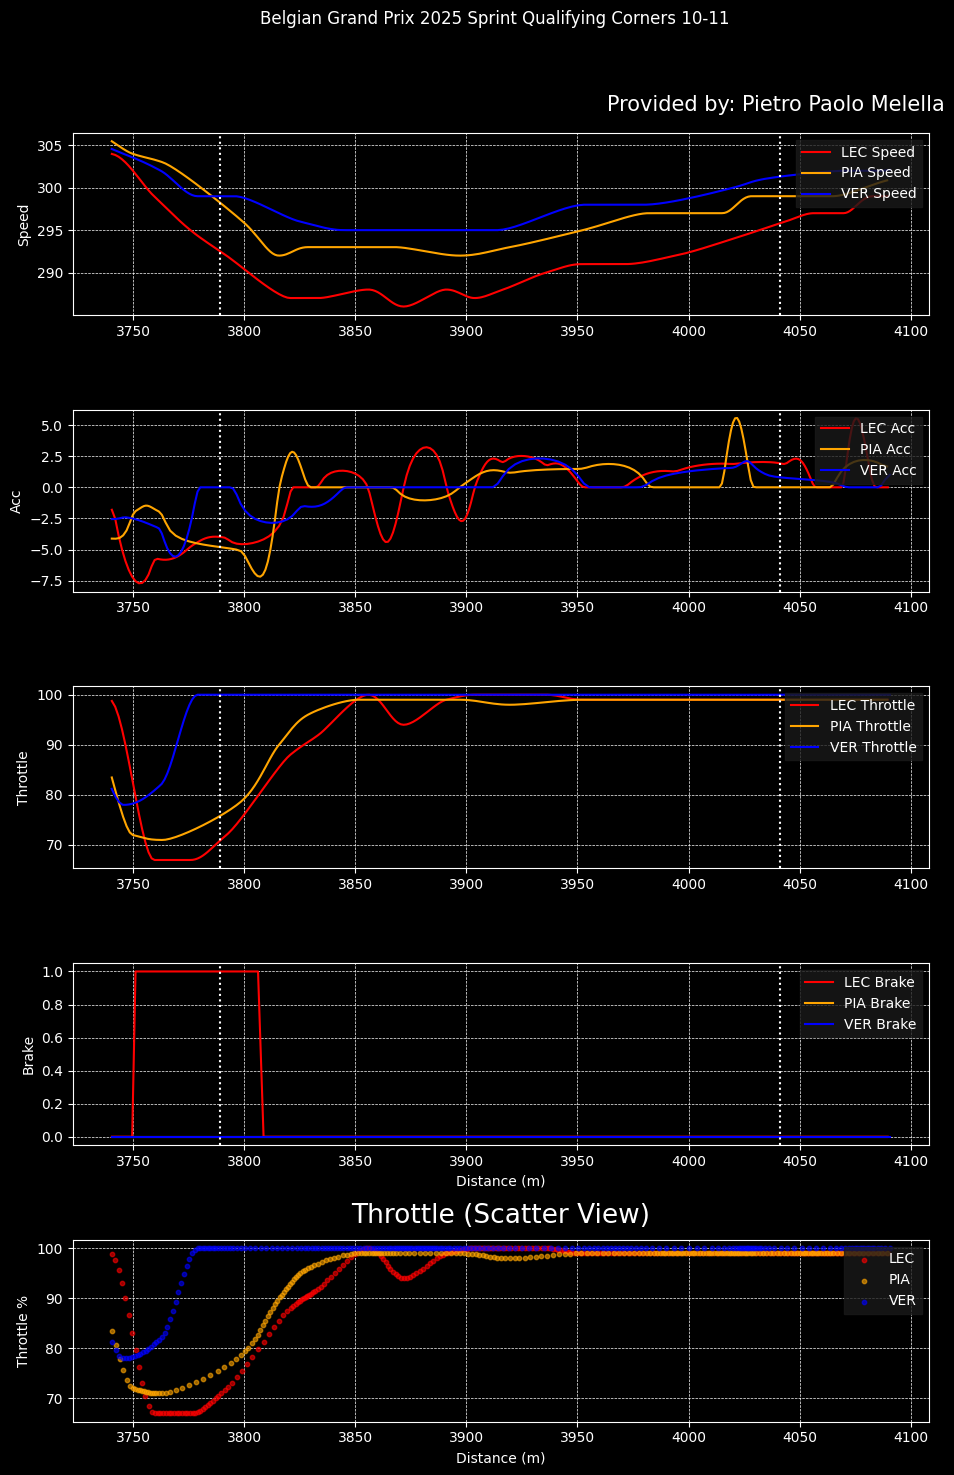

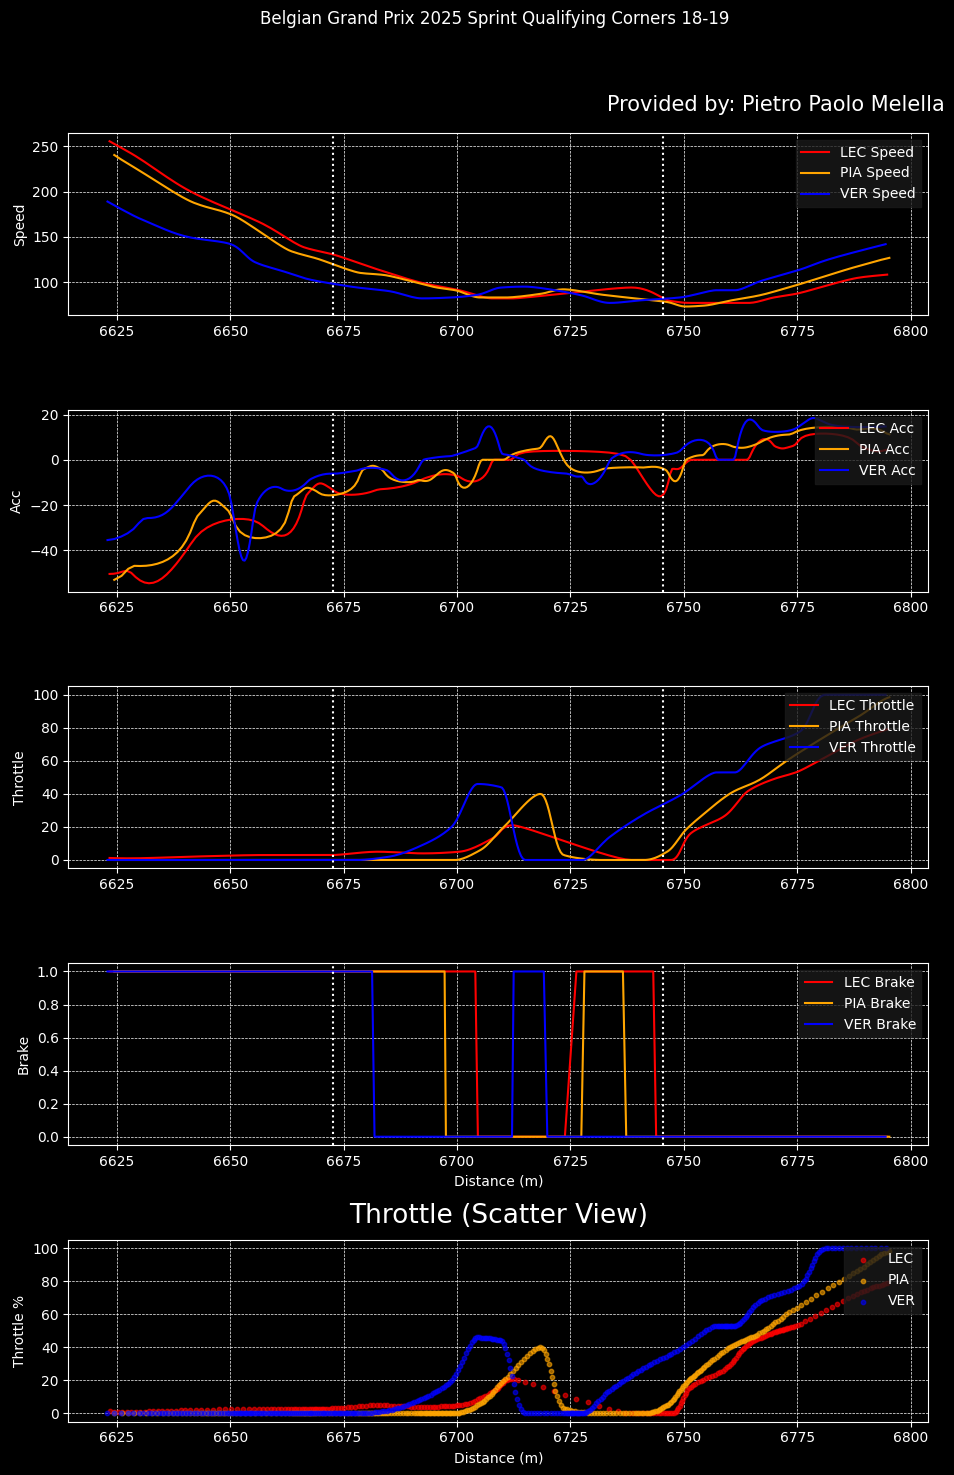

In [47]:
corners = [1,[10,11],[18,19]]

for corner in corners:
    ca = CornerAnalysis(
        drivers={
            'LEC': 'fastest',
            'PIA': 'fastest',
            'VER': 'fastest'
        },
        corner_idxs=corner,     # 1-based corner(s)
        before=50,
        after=50,
        session_label='Sprint Qualifying'
    )
    ca.plot_all()

In [48]:
class CornerMinThrottle:
    def __init__(self, session, corner_idxs, before=100, after=100, session_label='', n_drivers=None):
        """
        Analyze minimum throttle across all drivers for a specific corner or group of corners.

        :param session: FastF1 session object
        :param corner_idxs: int or list of 1-based corner numbers (e.g. 5 or [5,6])
        :param before: meters before apex to start extracting
        :param after: meters after apex to end extracting
        :param session_label: optional label to display in plot title
        :param n_drivers: limit to N fastest drivers (optional)
        """
        self.session = session
        self.corner_idxs = [corner_idxs] if isinstance(corner_idxs, int) else corner_idxs
        self.before = before
        self.after = after
        self.session_label = session_label

        # Load driver list
        laps = session.laps.pick_quicklaps()
        self.drivers = laps['Driver'].unique()

        if n_drivers:
            fastest_laps = laps.groupby('Driver')['LapTime'].min().nsmallest(n_drivers)
            self.drivers = fastest_laps.index.tolist()

        self.colors = {d: colors_pilots.get(d, 'white') for d in self.drivers}
        self.min_throttle = {}

        self._compute_min_throttle()

    def _compute_min_throttle(self):
        corners = circuit_info.corners['Distance'].values
        start = corners[min(i - 1 for i in self.corner_idxs)] - self.before
        end = corners[max(i - 1 for i in self.corner_idxs)] + self.after

        for d in self.drivers:
            try:
                lap = self.session.laps.pick_drivers(d).pick_fastest()
                tel = lap.get_car_data().add_distance()
                tel = interpolate_dataframe(tel)
                df = tel[(tel['Distance'] >= start) & (tel['Distance'] <= end)]
                self.min_throttle[d] = df['Throttle'].min() if not df.empty else None
            except Exception as e:
                print(f"[WARN] Skipping {d}: {e}")
                self.min_throttle[d] = None

    def plot(self):
        import matplotlib.pyplot as plt

        vals = {d: v for d, v in self.min_throttle.items() if v is not None}
        sorted_vals = dict(sorted(vals.items(), key=lambda item: item[1]))

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(
            sorted_vals.keys(),
            sorted_vals.values(),
            color=[self.colors[d] for d in sorted_vals.keys()]
        )

        ax.set_ylabel("Minimum Throttle (%)")
        label = f"Corner(s) {', '.join(str(i) for i in self.corner_idxs)}"
        title = f"{self.session.event['EventName']} {self.session.event.year} {self.session_label}\n{label}"
        ax.set_title(title)
        ax.set_ylim(0, 105)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 2,
                    f"{height:.0f}%", ha='center', va='bottom', color='white')

        fig.text(
            0.3, 0.91,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=15
        )

        plt.style.use('dark_background')
        plt.tight_layout()
        plt.show()

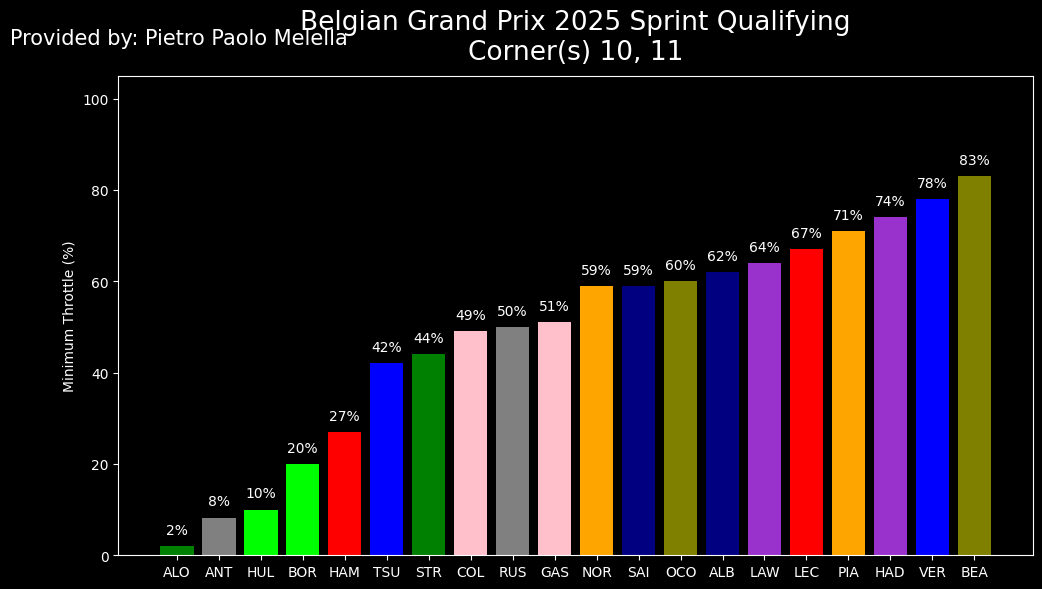

In [49]:
# Example: Min throttle in corner 5, ±100m
analyzer = CornerMinThrottle(
    session=session,           # your FastF1 session
    corner_idxs=[10,11],             # or [5,6,7] for multiple
    before=50,
    after=50,
    session_label='Sprint Qualifying',         # optional
    n_drivers=20               # optional: show only top 10
)

analyzer.plot()

In [50]:
class CornerMinSpeed:
    def __init__(self, session, corner_idxs, before=100, after=100, session_label='', n_drivers=None):
        """
        Analyze minimum speed across all drivers for a specific corner or group of corners.

        :param session: FastF1 session object
        :param corner_idxs: int or list of 1-based corner numbers (e.g. 5 or [5,6])
        :param before: meters before apex to start extracting
        :param after: meters after apex to end extracting
        :param session_label: optional label to display in plot title
        :param n_drivers: limit to N fastest drivers (optional)
        """
        self.session = session
        self.corner_idxs = [corner_idxs] if isinstance(corner_idxs, int) else corner_idxs
        self.before = before
        self.after = after
        self.session_label = session_label

        # Load driver list
        laps = session.laps.pick_quicklaps()
        self.drivers = laps['Driver'].unique()

        if n_drivers:
            fastest_laps = laps.groupby('Driver')['LapTime'].min().nsmallest(n_drivers)
            self.drivers = fastest_laps.index.tolist()

        self.colors = {d: colors_pilots.get(d, 'white') for d in self.drivers}
        self.min_speed = {}

        self._compute_min_speed()

    def _compute_min_speed(self):
        corners = circuit_info.corners['Distance'].values
        start = corners[min(i - 1 for i in self.corner_idxs)] - self.before
        end = corners[max(i - 1 for i in self.corner_idxs)] + self.after

        for d in self.drivers:
            try:
                lap = self.session.laps.pick_drivers(d).pick_fastest()
                tel = lap.get_car_data().add_distance()
                tel = interpolate_dataframe(tel)
                df = tel[(tel['Distance'] >= start) & (tel['Distance'] <= end)]
                self.min_speed[d] = df['Speed'].min() if not df.empty else None
            except Exception as e:
                print(f"[WARN] Skipping {d}: {e}")
                self.min_speed[d] = None

    def plot(self):
        import matplotlib.pyplot as plt

        vals = {d: v for d, v in self.min_speed.items() if v is not None}
        sorted_vals = dict(sorted(vals.items(), key=lambda item: item[1]))

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(
            sorted_vals.keys(),
            sorted_vals.values(),
            color=[self.colors[d] for d in sorted_vals.keys()]
        )

        ax.set_ylabel("Minimum Speed (km/h)")
        label = f"Corner(s) {', '.join(str(i) for i in self.corner_idxs)}"
        title = f"{self.session.event['EventName']} {self.session.event.year} {self.session_label}\n{label}"
        ax.set_title(title)
        ax.set_ylim(0, max(sorted_vals.values()) + 20)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                    f"{height:.0f} km/h", ha='center', va='bottom', color='white')

        fig.text(
            0.3, 0.91,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=15
        )

        plt.style.use('dark_background')
        plt.tight_layout()
        plt.show()

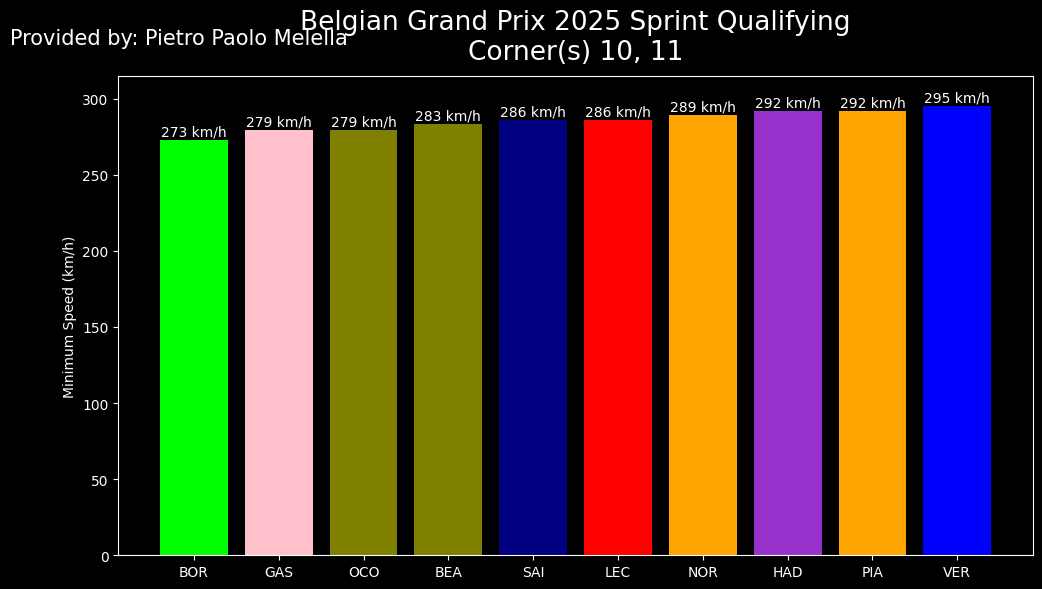

In [51]:
min_speed = CornerMinSpeed(
    session=session,
    corner_idxs=[10,11],         # or multiple like [9,10,11]
    before=30,
    after=30,
    session_label='Sprint Qualifying',  # Optional
    n_drivers=10             # Optional: limit to N fastest
)

min_speed.plot()

In [52]:
class CornerSpeedComparator:
    def __init__(self, drivers, n_interp=200, session_label=''):
        """
        :param drivers: list of driver codes, e.g. ['LEC','NOR','VER']
        :param n_interp: number of points to interpolate in each corner
        :param session_label: string to include in plot title
        """
        self.drivers = drivers
        self.n_interp = n_interp
        self.session_label = session_label
        self._assign_colors()
        self._load_laps()
        self._compute_corner_windows()
        self._compute_peaks()

    def _assign_colors(self):

        fallback_shades = {
            'red': ['white', 'lightcoral'],
            'blue': ['cyan', 'lightblue'],
            'orange': ['gold', 'wheat'],
            'grey': ['white', 'silver'],
            'green': ['lime', 'springgreen'],
            'pink': ['violet', 'lightpink'],
            'olive': ['khaki'],
            'navy': ['skyblue'],
            '#9932CC': ['plum'],
            'lime': ['yellowgreen']
        }

        used_colors = {}
        self.driver_color_map = {}
        self.palette = []

        for driver in self.drivers:
            base_color = colors_pilots.get(driver, 'white')
            count = used_colors.get(base_color, 0)
            if count == 0:
                color = base_color
            else:
                fallback = fallback_shades.get(base_color, ['white'])
                color = fallback[count - 1] if count - 1 < len(fallback) else 'white'
            used_colors[base_color] = count + 1
            self.driver_color_map[driver] = color
            self.palette.append(color)

    def _load_laps(self):
        self.lap_objs = []
        self.laps = []
        for d in self.drivers:
            lap_obj = transformed_laps.pick_drivers(d).pick_fastest()
            df = interpolate_dataframe(lap_obj.get_car_data().add_distance())
            df = compute_acceleration(df)
            self.lap_objs.append(lap_obj)
            self.laps.append({'name': d, 'df': df})

    def _compute_corner_windows(self):
        apexes = sorted(circuit_info.corners['Distance'].values)
        self.entries = [0.0] + [(apexes[i-1] + apexes[i]) / 2 for i in range(1, len(apexes))]
        self.exits = [(apexes[i] + apexes[i+1]) / 2 for i in range(len(apexes)-1)] + [
            max(lap['df']['Distance'].max() for lap in self.laps)
        ]
        self.apexes = apexes

    def _compute_peaks(self):
        peak_dict = {}
        for idx, (start, apex, end) in enumerate(
                zip(self.entries, self.apexes, self.exits), start=1):
            grid = np.linspace(start, end, self.n_interp)
            interp_speeds = {
                lap['name']: np.interp(grid, lap['df']['Distance'], lap['df']['Speed'])
                for lap in self.laps
            }
            peaks = {name: speeds.max() for name, speeds in interp_speeds.items()}
            peak_dict[f" {idx}"] = peaks
        self.df_peaks = pd.DataFrame(peak_dict).T

    def plot_peak_speeds(self, figsize=(12,6)):
        fig, ax = plt.subplots(figsize=figsize)
        self.df_peaks.plot.bar(
            ax=ax, rot=0,
            color=[self.driver_color_map[d] for d in self.df_peaks.columns]
        )

        event = session.event['EventName']
        year  = session.event.year
        ax.set_xlabel("Turn")
        ax.set_ylabel("Peak Speed (km/h)")
        ax.set_title(f"Turn Peak Speeds {event} {year} {self.session_label}")
        ax.legend(
            title="Driver",
            loc='upper left',
            bbox_to_anchor=(1.02, 1),
            fontsize=8
        )

        for i, corner in enumerate(self.df_peaks.index):
            speeds = self.df_peaks.loc[corner]
            winner = speeds.idxmax()
            win_speed = speeds[winner]
            lines = [f"{winner}: {win_speed:.0f}"]
            for d in self.drivers:
                if d == winner:
                    continue
                diff = int(speeds[d] - win_speed)
                lines.append(f"{d}: {diff:+d}")
            text = "\n".join(lines)
            ax.text(i, win_speed + 3, text, ha='center', va='bottom',
                    color='white', fontsize=6)

        fig.text(
            0.3, 1.75,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=10
        )

        plt.tight_layout(rect=[0, 0, 1.3, 1.8])
        plt.show()

### 🚀 Peak Speed per Corner

This plot shows the peak speed reached by each driver in every corner.  
It highlights which drivers are the fastest in straight-line sections versus technical turns.  
Use this to assess raw speed and confidence through specific sections of the track.

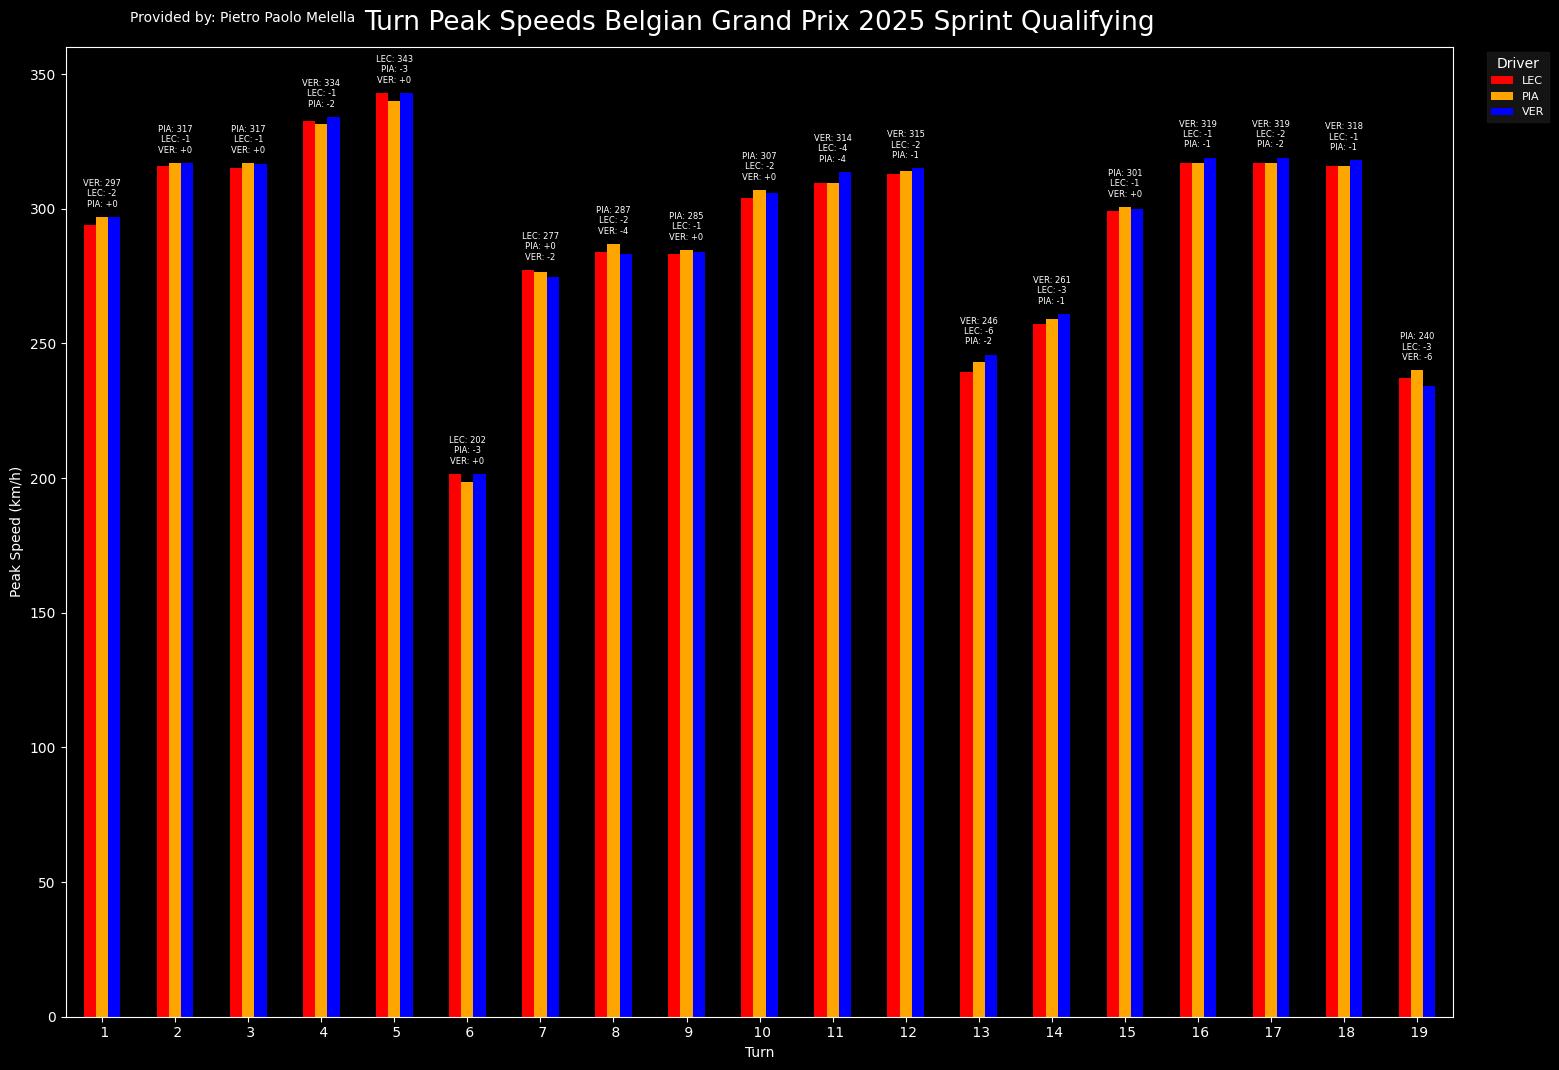

In [53]:
comp = CornerSpeedComparator(
    drivers=['LEC', 'PIA', 'VER'],
    session_label='Sprint Qualifying',
)

comp.plot_peak_speeds()

### 🏁 Fastest Driver per Corner

This visualization shows the percentage of corners where each driver was the fastest.  
It provides a clear picture of corner dominance and consistency across the lap.  
Higher shares suggest better grip, balance, or driver confidence in various track sectors.

In [54]:
class FastestTurnShare:
    """
    Compute and plot the percentage share of corners each driver was fastest.
    """
    def __init__(self, drivers, session, n_interp=200, session_label=''):
        """
        :param drivers: list of driver codes, e.g. ['LEC','NOR','VER']
        :param session: FastF1 session object (with .event info loaded)
        :param n_interp: number of interpolation points per corner
        """
        self.drivers = drivers
        self.session = session
        self.n_interp = n_interp
        self.session_label = session_label

        self._assign_colors()
        self._load_laps()
        self._compute_corner_windows()
        self._compute_peaks()

    def _assign_colors(self):

        fallback_shades = {
            'red': ['lightcoral', 'white'],
            'blue': ['cyan', 'lightblue'],
            'orange': ['gold', 'wheat'],
            'grey': ['silver', 'white'],
            'green': ['lime', 'springgreen'],
            'pink': ['violet', 'lightpink'],
            'olive': ['khaki'],
            'navy': ['skyblue'],
            '#9932CC': ['plum'],
            'lime': ['yellowgreen']
        }

        used_colors = {}
        self.driver_color_map = {}

        for driver in self.drivers:
            base_color = colors_pilots.get(driver, 'white')
            count = used_colors.get(base_color, 0)
            if count == 0:
                color = base_color
            else:
                fallback = fallback_shades.get(base_color, ['white'])
                color = fallback[count - 1] if count - 1 < len(fallback) else 'white'
            used_colors[base_color] = count + 1
            self.driver_color_map[driver] = color

    def _load_laps(self):
        self.laps = []
        for d in self.drivers:
            lap_obj = transformed_laps.pick_drivers(d).pick_fastest()
            df = lap_obj.get_car_data().add_distance()
            df = interpolate_dataframe(df)
            df = compute_acceleration(df)
            self.laps.append({'name': d, 'df': df})

    def _compute_corner_windows(self):
        apexes = sorted(circuit_info.corners['Distance'].values)
        self.entries = [0.0] + [(apexes[i-1] + apexes[i])/2 for i in range(1, len(apexes))]
        self.exits   = [(apexes[i] + apexes[i+1])/2 for i in range(len(apexes)-1)] + \
                       [max(lap['df']['Distance'].max() for lap in self.laps)]
        self.apexes = apexes

    def _compute_peaks(self):
        peak_dict = {}
        for idx, (start, apex, end) in enumerate(zip(self.entries, self.apexes, self.exits), start=1):
            grid = np.linspace(start, end, self.n_interp)
            speeds = {
                lap['name']: np.interp(grid, lap['df']['Distance'], lap['df']['Speed'])
                for lap in self.laps
            }
            peaks = {name: sp.max() for name, sp in speeds.items()}
            peak_dict[f"Turn {idx}"] = peaks
        self.df_peaks = pd.DataFrame(peak_dict).T

    def plot_share(self, figsize=(6,6)):
        winners = self.df_peaks.idxmax(axis=1)
        counts = winners.value_counts().reindex(self.drivers, fill_value=0)
        labels = counts.index.tolist()
        sizes  = counts.values.tolist()

        # Replace white with lightgrey for visibility
        colors = [
            'lightgrey' if self.driver_color_map.get(d, 'white') == 'white'
            else self.driver_color_map.get(d)
            for d in labels
        ]

        fig, ax = plt.subplots(figsize=figsize)
        ax.pie(
            sizes,
            labels=labels,
            colors=colors,
            autopct='%1.1f%%',
            startangle=90
        )

        title = f"{self.session.event['EventName']} {self.session.event.year} {self.session_label}"
        ax.set_title(f"{title}\nFastest-Turn Share")

        fig.text(
            0.90, 0.83,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=15
        )

        plt.tight_layout()
        plt.show()

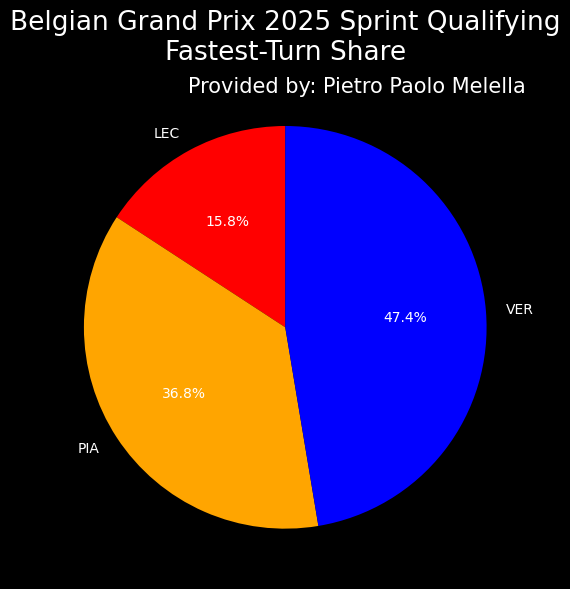

In [55]:
fts = FastestTurnShare(
    drivers=['LEC', 'PIA', 'VER'],
    session=session,
    session_label='Sprint Qualifying',
)

fts.plot_share()

In [56]:
from typing import Optional, List
from dataclasses import dataclass, field
import mplcursors

@dataclass
class TrackTelemetryVisualizer:
    """
    Enhanced interactive plot of a driver's fastest lap telemetry.

    Features:
      - Color by one channel (B→G→R or plasma)
      - Variable linewidth by a second channel (e.g. speed)
      - Corner annotations
      - Sector boundary markers
      - Brake/low-throttle highlights
      - Interactive tooltips via mplcursors
      - Auto-title and save() method
    """
    laps: any                                  # pre-filtered laps DataFrame
    circuit_info: any                          # session.get_circuit_info()
    driver: str                               # driver code
    color_channel: str = 'Throttle'           # channel for color
    width_channel: Optional[str] = 'Speed'    # channel for width, None to disable
    annotate_corners: bool = False            # show corner labels
    highlight_brake: bool = False             # mark throttle < threshold
    brake_threshold: float = 10.0             # throttle % threshold
    annotate_sectors: bool = False            # mark sector boundaries
    event_name: Optional[str] = None          # for title
    year: Optional[int] = None
    session_name: Optional[str] = None
    use_bgr_scale: bool = False

    # internal fields populated in __post_init__
    x: np.ndarray = field(init=False)
    y: np.ndarray = field(init=False)
    data_color: np.ndarray = field(init=False)
    data_width: np.ndarray = field(init=False)
    segments: np.ndarray = field(init=False)

    def __post_init__(self):
        # extract telemetry
        lap = self.laps.pick_drivers([self.driver]).pick_fastest()
        tel = lap.telemetry
        self.x = tel['X'].values
        self.y = tel['Y'].values
        self.data_color = tel[self.color_channel].values
        if self.width_channel:
            self.data_width = tel[self.width_channel].values
        else:
            self.data_width = np.full_like(self.data_color, fill_value=1.0)
        # build segments
        pts = np.vstack([self.x, self.y]).T.reshape(-1,1,2)
        self.segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        # store rotation angle
        self._angle = self.circuit_info.rotation / 180 * np.pi
        # store lap for sector annotations
        self._lap = lap

    @staticmethod
    def _rotate(xy: np.ndarray, *, angle: float) -> np.ndarray:
        mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
        return xy.dot(mat)

    def plot(self,
             track_color: str = '#888888',
             bg_linewidth: float = 14.0,
             data_linewidth: float = 4.0,
             figsize=(12,7),
             colorbar_orientation: str = 'vertical'):
        """
        Render the lap with:
          - grey outline (bg_linewidth)
          - B→G→R or plasma telemetry coloring
          - variable linewidth by width_channel
          - optional corner annotations
          - sector boundary markers
          - brake/low-throttle highlights
          - interactive tooltips
          - vertical colorbar with ticks at min/mid/max
          - automatic title if event_name/year/session_name provided
        """
        # Prepare figure and axes
        fig, ax = plt.subplots(figsize=figsize, facecolor='#222222')
        ax.set_facecolor('#222222')
        ax.axis('off')

        # Rotate coordinates to circuit orientation
        coords = np.vstack([self.x, self.y]).T
        rot = self._rotate(coords, angle=self._angle)
        X, Y = rot[:,0], rot[:,1]
        pts = rot.reshape(-1,1,2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

        # Draw track outline
        ax.plot(X, Y,
                color=track_color,
                linewidth=bg_linewidth,
                solid_capstyle='round',
                zorder=0)

        # Choose colormap
        cmap = (LinearSegmentedColormap.from_list('bgr',['blue','green','red'])
                if self.use_bgr_scale else mpl.cm.plasma)
        vmin, vmax = self.data_color.min(), self.data_color.max()
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        # Compute variable linewidths safely
        if self.data_width.max() != self.data_width.min():
            widths = (
                0.5
                + 4 * (self.data_width - self.data_width.min())
                / (self.data_width.max() - self.data_width.min())
            )
        else:
            widths = np.full_like(self.data_color, 2.0)

        # Plot telemetry LineCollection
        lc = LineCollection(segs,
                            cmap=cmap,
                            norm=norm,
                            linewidth=widths,
                            capstyle='butt',
                            zorder=1)
        lc.set_array(self.data_color)
        ax.add_collection(lc)

        # Interactive tooltips
        cursor = mplcursors.cursor(lc, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            idx = sel.target.index
            txt = f"{self.color_channel}: {self.data_color[idx]:.1f}"
            if self.width_channel:
                txt += f"\n{self.width_channel}: {self.data_width[idx]:.1f}"
            sel.annotation.set_text(txt)
            sel.annotation.get_bbox_patch().set(fc='white', alpha=0.8)

        # Highlight brake/low-throttle zones
        if self.highlight_brake:
            idxs = np.where(self.data_color < self.brake_threshold)[0]
            ax.scatter(rot[idxs,0], rot[idxs,1],
                       color='white', edgecolor='black',
                       s=30, zorder=2, label='Brake')

                        # Sector boundary markers (approximate by geometry)
        if self.annotate_sectors:
            # compute cumulative distance along the raw track
            coords_raw = np.vstack([self.x, self.y]).T
            deltas = np.linalg.norm(np.diff(coords_raw, axis=0), axis=1)
            cumdist = np.insert(np.cumsum(deltas), 0, 0)
            total = cumdist[-1]
            # place markers at 1/3 and 2/3 of lap distance
            for frac in (1/3, 2/3):
                target = total * frac
                i = np.argmin(np.abs(cumdist - target))
                # rotate and plot
                pt = coords_raw[i]
                rpt = self._rotate(pt.reshape(1,2), angle=self._angle)[0]
                ax.scatter(rpt[0], rpt[1], color='yellow', s=70, edgecolor='black', zorder=2)

        # Corner annotations
        if self.annotate_corners:
            offset = np.array([500, 0])
            for _, c in self.circuit_info.corners.iterrows():
                base = np.array([c['X'], c['Y']])
                offp = self._rotate(offset, angle=c['Angle']/180*np.pi)
                txtp = self._rotate(base+offp, angle=self._angle)
                bp   = self._rotate(base, angle=self._angle)
                ax.scatter(txtp[0], txtp[1],
                           color='white', s=150,
                           edgecolor='grey', linewidth=1.5, zorder=2)
                ax.plot([bp[0],txtp[0]], [bp[1],txtp[1]],
                        color='grey', linewidth=1.0, zorder=1)
                ax.text(txtp[0], txtp[1], f"{c['Number']}{c['Letter']}",
                        ha='center', va='center', color='black', fontsize=9, zorder=3)

        # Colorbar with ticks at min/mid/max
        cbar = fig.colorbar(lc, ax=ax,
                            orientation=colorbar_orientation,
                            pad=0.02, shrink=0.6)
        mid = 0.5*(vmin+vmax)
        cbar.set_ticks([vmin, mid, vmax])
        cbar.set_ticklabels([f"{vmin:.0f}", f"{mid:.0f}", f"{vmax:.0f}"])
        cbar.ax.yaxis.set_tick_params(labelsize=10, color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
        cbar.set_label(self.color_channel,
                       labelpad=10, fontsize=12, color='white')

        # Automatic title
        if self.event_name and self.year and self.session_name:
            full = f"{self.event_name} {self.year} {self.session_name}, {self.driver} — {self.color_channel}"
            ax.set_title(full, fontsize=16, color='white', pad=20)
            
        # Annotate signature
        fig.text(
            0.92, 0.87,
            "Provided by: Pietro Paolo Melella",
            ha='right', va='bottom',
            color='white', fontsize=15
        )

        plt.show()


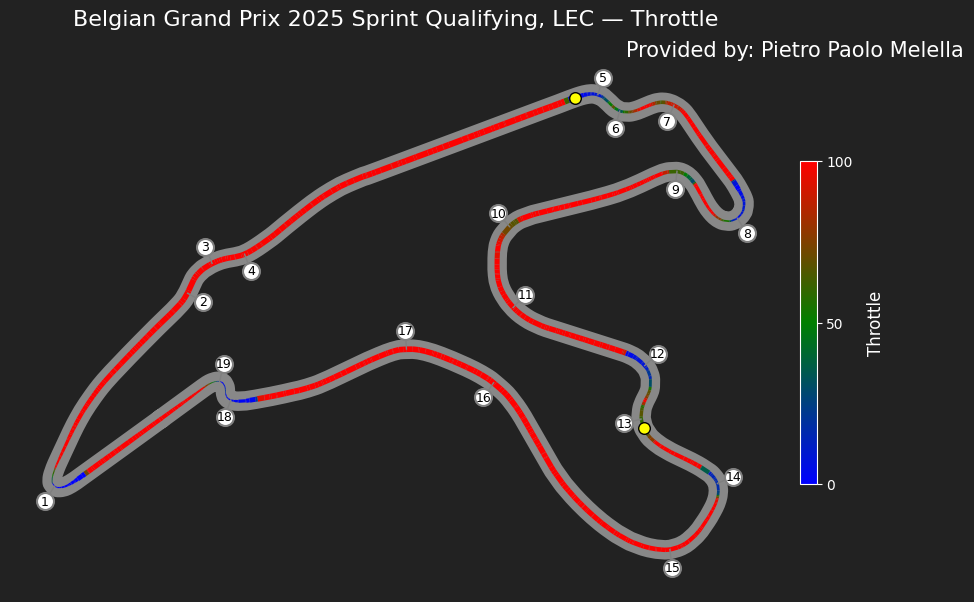

In [57]:
vis1 = TrackTelemetryVisualizer(
    laps=laps,
    circuit_info=circuit_info,
    driver='LEC',
    color_channel='Throttle',
    width_channel='Speed',
    annotate_corners=True,
    highlight_brake=False,      # ← disable the white‐dot brake markers
    annotate_sectors=True,     # leave sector markers off
    event_name='Belgian Grand Prix',
    year=2025,
    session_name='Sprint Qualifying',
    use_bgr_scale=True
)
vis1.plot()

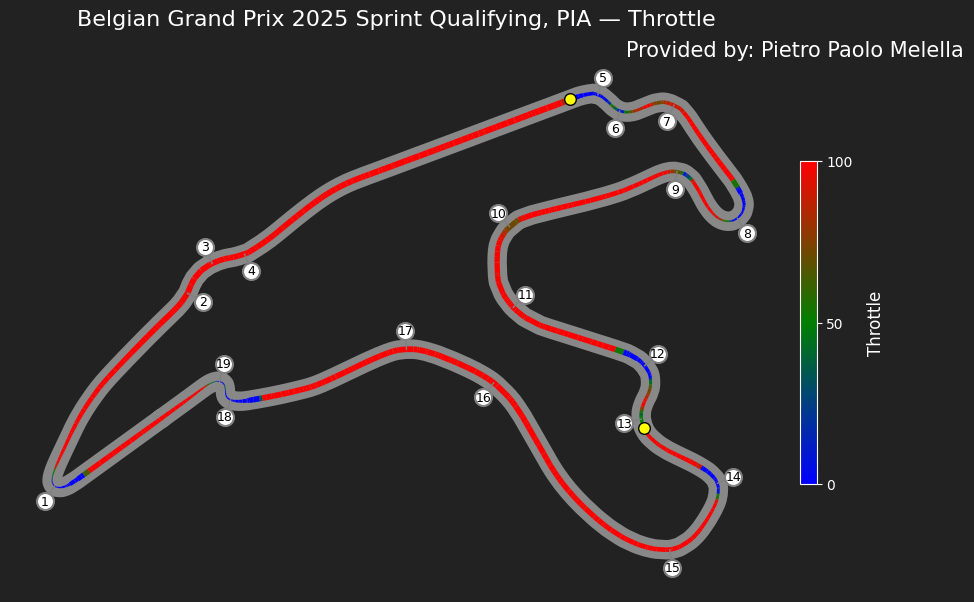

In [58]:
vis2 = TrackTelemetryVisualizer(
    laps=laps,
    circuit_info=circuit_info,
    driver='PIA',
    color_channel='Throttle',
    width_channel='Speed',
    annotate_corners=True,
    highlight_brake=False,      # ← disable the white‐dot brake markers
    annotate_sectors=True,     # leave sector markers off
    event_name='Belgian Grand Prix',
    year=2025,
    session_name='Sprint Qualifying',
    use_bgr_scale=True
)
vis2.plot()